# don't be plastic, elastipy!

Hi there, this tutorial is actually a [jupyter notebook](https://jupyter.org/) and can be found in [examples](https://github.com/defgsus/elastipy/blob/development/examples/)/[tutorial.ipynb](https://github.com/defgsus/elastipy/blob/development/examples/tutorial.ipynb)

In [1]:
# hidden

# here we just add the parent path of this notebook to 
# the path list where python modules are searched.
# So we find elastipy even if it's not installed via setup.py
import sys
sys.path.insert(0, "..")

## exporting some objects

Without too much thinking we can just use the built-in export helper
and generate some data.

In [2]:
from elastipy import Exporter

class ShapeExporter(Exporter):
    INDEX_NAME = "elastipy-example-shapes"
    MAPPINGS = {
        "properties": {
            "shape": {"type": "keyword"},
            "color": {"type": "keyword"},
            "area": {"type": "float"},
        }
    }

The **INDEX_NAME** is obviously the name of the elasticsearch index. 
The **MAPPINGS** parameter describes the 
[elasticsearch mapping](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping.html). 
Here we say that documents will at least have these common fields, 
one of type **float** and two of type **keyword** which means they 
are strings but not full-text searchable ones. Instead they are 
efficiently indexed and aggregatable.

The data we create out of thin air.. 

In [69]:
import random

def shape_generator(count=1000):
    for i in range(count):
        yield {
            "shape": random.choice(("triangle", "square")),
            "color": random.choice(("red", "green", "blue")),
            "area": random.gauss(5, 1.3),
        }

Now create our exporter and export a couple of documents. It uses the [bulk helper tools](https://elasticsearch-py.readthedocs.io/en/7.10.0/helpers.html#bulk-helpers) internally.

In [70]:
exporter = ShapeExporter()
count, errors = exporter.export_list(shape_generator())
print(count, "exported")

1000 exported


## query oh elastipyia 

In most cases this import is enough to access all the good stuff:

In [5]:
from elastipy import Search, query

Now get some documents:

In [6]:
s = Search(index="elastipy-example-shapes")

**s** is now a search request that can be configured. Setting any search related options will always return a new instance. Here we set the maximum number of documents to respond:

In [7]:
s = s.size(3)

Next we add a [query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl.html), more specifically a [term query](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-term-query.html).

In [8]:
s = s.term(field="color", value="green")

Our request to elasticsearch would look like this right now:

In [9]:
s.dump_body()

{
  "query": {
    "term": {
      "color": {
        "value": "green"
      }
    }
  },
  "size": 3
}


More queries can be added, which defaults to an **AND** combination:

In [10]:
s = s.range(field="area", gt=5.)
s.dump_body()

{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "color": {
              "value": "green"
            }
          }
        },
        {
          "range": {
            "area": {
              "gt": 5.0
            }
          }
        }
      ]
    }
  },
  "size": 3
}


**OR** combinations can be archived with the [bool](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-bool-query.html) query itself or by applying the `|` operator to the query classes in `elastipy.query`:

In [11]:
s = s | (query.Term(field="color", value="red") & query.Range(field="area", gt=8.))
s.dump_body()

{
  "query": {
    "bool": {
      "should": [
        {
          "bool": {
            "must": [
              {
                "term": {
                  "color": {
                    "value": "green"
                  }
                }
              },
              {
                "range": {
                  "area": {
                    "gt": 5.0
                  }
                }
              }
            ]
          }
        },
        {
          "bool": {
            "must": [
              {
                "term": {
                  "color": {
                    "value": "red"
                  }
                }
              },
              {
                "range": {
                  "area": {
                    "gt": 8.0
                  }
                }
              }
            ]
          }
        }
      ]
    }
  },
  "size": 3
}


Better execute the search now before the body get's too complicated:

In [12]:
response = s.execute()
response.dump()

{
  "took": 6,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": 505,
    "max_score": 2.1122031,
    "hits": [
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "OH65DXcBeebHNMb6yFT6",
        "_score": 2.1122031,
        "_source": {
          "shape": "triangle",
          "color": "red",
          "area": 9.81123291961843
        }
      },
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "O365DXcBeebHNMb6yFT6",
        "_score": 2.1122031,
        "_source": {
          "shape": "triangle",
          "color": "red",
          "area": 9.422377896491687
        }
      },
      {
        "_index": "elastipy-example-shapes",
        "_type": "_doc",
        "_id": "QH65DXcBeebHNMb6yFT6",
        "_score": 2.1122031,
        "_source": {
          "shape": "square",
          "color": "red",
          "area": 8.0

The response object is a small wrapper around `dict` that has some convenience properties.

In [13]:
response.documents

[{'shape': 'triangle', 'color': 'red', 'area': 9.81123291961843},
 {'shape': 'triangle', 'color': 'red', 'area': 9.422377896491687},
 {'shape': 'square', 'color': 'red', 'area': 8.090358296963972}]

---

The functions and properties are tried to make chainable in a way that allows for short and powerful oneliners: 

In [15]:
Search(index="elastipy-example-shapes") \
    .size(20).sort("-area").execute().documents

[{'shape': 'square', 'color': 'blue', 'area': 9.99927423003294},
 {'shape': 'triangle', 'color': 'green', 'area': 9.991875438972691},
 {'shape': 'triangle', 'color': 'blue', 'area': 9.991462210156053},
 {'shape': 'triangle', 'color': 'blue', 'area': 9.987935667586568},
 {'shape': 'square', 'color': 'red', 'area': 9.985136515039924},
 {'shape': 'triangle', 'color': 'green', 'area': 9.980948791957655},
 {'shape': 'triangle', 'color': 'red', 'area': 9.979456153451741},
 {'shape': 'square', 'color': 'green', 'area': 9.979385991503124},
 {'shape': 'square', 'color': 'red', 'area': 9.977829259412312},
 {'shape': 'triangle', 'color': 'green', 'area': 9.976357130797751},
 {'shape': 'square', 'color': 'green', 'area': 9.974790391463257},
 {'shape': 'triangle', 'color': 'blue', 'area': 9.972795370592197},
 {'shape': 'square', 'color': 'red', 'area': 9.964632134624988},
 {'shape': 'square', 'color': 'red', 'area': 9.96207946010818},
 {'shape': 'square', 'color': 'green', 'area': 9.961814048179983

So this was the document response. Let's dive inside and start aggregating on fields.

## agitated aggregation

Aggregations can be created using the `agg_`, `metric_` and `pipeline_` prefixes. An aggregation is **attached** to the `Search` instance, so there is no copying like with the queries above.

In [26]:
s = Search(index="elastipy-example-shapes").size(0)

agg = s.agg_terms(field="shape")

s.dump_body()

{
  "aggregations": {
    "a0": {
      "terms": {
        "field": "shape"
      }
    }
  },
  "query": {
    "match_all": {}
  },
  "size": 0
}


As we can see, a [terms aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-terms-aggregation.html)
has been added to the search body. The names of aggregations are auto-generated, but can be explicitly stated:

In [27]:
s = Search(index="elastipy-example-shapes").size(0)

agg = s.agg_terms("shapes", field="shape")

s.dump_body()

{
  "aggregations": {
    "shapes": {
      "terms": {
        "field": "shape"
      }
    }
  },
  "query": {
    "match_all": {}
  },
  "size": 0
}


Let's look at the result from elasticsearch:

In [28]:
s.execute()
s.dump_response()

{
  "took": 4,
  "timed_out": false,
  "_shards": {
    "total": 1,
    "successful": 1,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": 12000,
    "max_score": null,
    "hits": []
  },
  "aggregations": {
    "shapes": {
      "doc_count_error_upper_bound": 0,
      "sum_other_doc_count": 0,
      "buckets": [
        {
          "key": "triangle",
          "doc_count": 6046
        },
        {
          "key": "square",
          "doc_count": 5954
        }
      ]
    }
  }
}


### valuable access

Because we kept the `agg` variable, we can use it's interface to access the values more conveniently:

In [29]:
agg.to_dict()

{'triangle': 6046, 'square': 5954}

It supports the `items()`, `keys()` and `values()` generators as known from the `dict` type:

In [33]:
for key, value in agg.items():
    print(f"{key:12} {value}")

triangle     6046
square       5954


It also has a `dict_rows()` generator which preseves the **names** and **keys** of the aggregation:

In [34]:
for row in agg.dict_rows():
    print(row)

{'shapes': 'triangle', 'shapes.doc_count': 6046}
{'shapes': 'square', 'shapes.doc_count': 5954}


The `rows()` generator flattens the `dict_rows()` into a CSV-style list:

In [36]:
for row in agg.rows():
    print(row)

['shapes', 'shapes.doc_count']
['triangle', 6046]
['square', 5954]


And we can print a nice table to the command-line:

In [37]:
agg.print.table()

shapes   │ shapes.doc_count                            
─────────┼─────────────────────────────────────────────
triangle │ 6046 ██████████████████████████████████████▉
square   │ 5954 ██████████████████████████████████████▍


Obviously, at this point a couple of users would not understand why there is no conversion to a 
[pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) built in:

In [39]:
agg.to_pandas()  # or simply agg.df()

,shapes.doc_count
shapes,
triangle,6046
square,5954


The **index** and **columns** are assigned automatically. Also columns containing ISO-formatted date strings will be converted to `pandas.Timestamp`.

With `matplotlib` installed we can access the [pandas plotting interface](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html):  

<AxesSubplot:xlabel='shapes'>

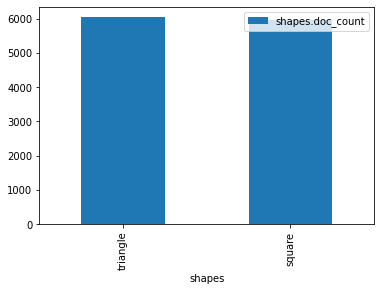

In [40]:
agg.df().plot.bar()

Now let's look into the details when **metrics** or nested **bucket** aggregations are involved.

### deeper aggregation agitation 

In [71]:
agg = Search(index="elastipy-example-shapes") \
    .agg_terms("shapes", field="shape") \
    .agg_terms("colors", field="color") \
    .metric_sum("area", field="area") \
    .metric_avg("avg-area", field="area") \
    .execute()

A few notes:
  - `agg_` methods always return the newly created aggregation, so the `colors` aggregation is nested inside the `shapes` aggregation.
  - `metric_` methods return their parent aggregation (because metrics do not allow a nested aggregation), so we can just continue to call `metric_*` and each time we add a metric to the `colors` aggregation. If you need to get access to the metric object itself add the `return_self=True` parameter.
  - The `execute` method on an aggregation does not return the response but the aggregation itself.
  
Now, what does the `to_dict` output look like?

In [72]:
agg.to_dict()

{('triangle', 'red'): 2211,
 ('triangle', 'green'): 2186,
 ('triangle', 'blue'): 2161,
 ('square', 'blue'): 2195,
 ('square', 'green'): 2145,
 ('square', 'red'): 2102}

It has put the **keys** that lead to each value into tuples. Without a lot of thinking we can say:

In [73]:
data = agg.to_dict()
print(f"There are {data[('triangle', 'red')]} red triangles in the database!")

There are 2211 red triangles in the database!


But where are the metrics gone?

Generally, `keys()`, `values()`, `items()`, `to_dict()` and `to_matrix()` only access the values of the current aggregation (which is `colors` in the example). Although all the keys of the parent **bucket** aggregations that lead to the values are included.

The methods `dict_rows()`, `rows()`, `to_pandas()` and `print.table()` will access all values from the whole aggregation branch. In this example it looks like this:

- shapes
  - colors
    - area
    - avg-area

In [74]:
agg.print.table(digits=3)

shapes   │ shapes.doc_count    │ colors │ colors.doc_count    │ area                    │ avg-area            
─────────┼─────────────────────┼────────┼─────────────────────┼─────────────────────────┼─────────────────────
triangle │ 6558 ██████████████ │ red    │ 2211 █████████████▉ │ 8315.542 ██████████████ │ 3.761 ██████████████
triangle │ 6558 ██████████████ │ green  │ 2186 █████████████▊ │ 8197.348 █████████████▊ │  3.75 █████████████▉
triangle │ 6558 ██████████████ │ blue   │ 2161 █████████████▋ │ 7984.779 █████████████▌ │ 3.695 █████████████▊
square   │ 6442 █████████████▊ │ blue   │ 2195 █████████████▉ │ 8045.931 █████████████▋ │ 3.666 █████████████▋
square   │ 6442 █████████████▊ │ green  │ 2145 █████████████▋ │  7947.46 █████████████▍ │ 3.705 █████████████▊
square   │ 6442 █████████████▊ │ red    │ 2102 █████████████▍ │ 7901.127 █████████████▍ │ 3.759 █████████████▉


Now all information is in the table. Note that the `shapes.doc_count` column contains the same value multiple times. This is because each `colors` aggregation bucket splits the `shapes` bucket into multiple results, without changing the overall count of the shapes, of course. 

Now what is this method with the awesome name `to_matrix`?

In [80]:
names, keys, matrix = agg.to_matrix()
print("names ", names)
print("keys  ", keys)
print("matrix", matrix)

names  ['shapes', 'colors']
keys   [['triangle', 'square'], ['red', 'green', 'blue']]
matrix [[2211, 2186, 2161], [2102, 2145, 2195]]


It produces a heatmap! At least in two dimensions. In this example we have two dimensions from the **bucket** aggregations `shapes` and `colors`. `to_matrix()` will produce a matrix with any number of dimensions, but if it's one or two, we can also convert it to a `DataFrame`:

In [81]:
agg.df_matrix()

,red,green,blue
triangle,2211,2186,2161
square,2102,2145,2195


And having something like [seaborn](https://seaborn.pydata.org/) installed we can easily plot it:

<AxesSubplot:>

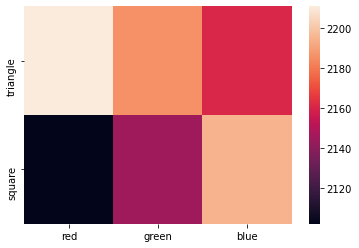

In [85]:
import seaborn as sns

sns.heatmap(agg.df_matrix())